# Image Recognition with PCA - Lab

## Introduction

In this lab, you'll explore the classic MNIST dataset of handwritten digits. While not as large as the previous dataset on facial image recognition, it still provides a 64-dimensional dataset that is ripe for feature reduction.

## Objectives

In this lab you will: 

- Use PCA to discover the principal components with images 
- Use the principal components of  a dataset as features in a machine learning model 
- Calculate the time savings and performance gains of layering in PCA as a preprocessing step in machine learning pipelines 

## Load the data

Load the `load_digits` dataset from the `datasets` module of scikit-learn. 

In [1]:
# Load the dataset
from sklearn.datasets import load_digits

data = load_digits()

print(data.data.shape, data.target.shape)

(1797, 64) (1797,)


## Preview the dataset

Now that the dataset is loaded, display the first 20 images.

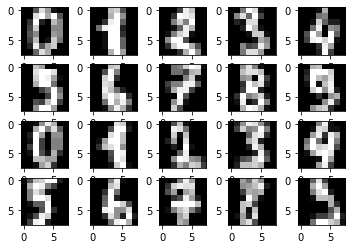

In [7]:
# Display the first 20 images 
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=5, nrows=4)

for i in range(20):
    ax = axes[i//5][i%5]
    ax.imshow(data.images[i], cmap=plt.cm.gray);

## Baseline model

Now it's time to fit an initial baseline model. 

- Split the data into training and test sets. Set `random_state=22` 
- Fit a support vector machine to the dataset. Set `gamma='auto'` 
- Record the training time 
- Print the training and test accucary of the model 

In [12]:
# Split the data
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = data.data
y = data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=22)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1347, 64) (450, 64) (1347,) (450,)


In [15]:
# Fit a naive model
import time

clf = SVC(gamma='auto')
start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print(f'Training time: {1000*(end - start)} microseconds')

Training time: 191.74909591674805 microseconds


In [16]:
# Training and test accuracy
from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, clf.predict(X_train))
test_acc = accuracy_score(y_test, clf.predict(X_test))
print('Training Accuracy: {}\nTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0
Testing Accuracy: 0.58


### Grid search baseline

Refine the initial model by performing a grid search to tune the hyperparameters. The two most important parameters to adjust are `'C'` and `'gamma'`. Once again, be sure to record the training time as well as the training and test accuracy.

In [24]:
# default gamma
1/(64*X_train.var())

0.00043286774502295704

In [23]:
# auto gamma
1/64

0.015625

In [26]:
# Your code here
# ⏰ Your code may take several minutes to run

from sklearn.model_selection import GridSearchCV

clf = SVC()

param_grid = [
    {'C': [0.001, 0.01, 0.1, 1, 100, 1000],
     'gamma': [0.001, 0.01, 0.1, 1]}
]

search = GridSearchCV(clf, param_grid, return_train_score=True)

search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 100, 1000],
                          'gamma': [0.001, 0.01, 0.1, 1]}],
             return_train_score=True)

In [29]:
# Print the best parameters 
search.best_params_

{'C': 100, 'gamma': 0.001}

In [44]:
import pandas as pd
# store cv_results_ as dataframe
search_results = pd.DataFrame(search.cv_results_)
# find mean train score for best estimator
mean_train=search_results.loc[search_results.params==search.best_params_, 'mean_train_score']
# inspect
print(type(mean_train))
mean_train

<class 'pandas.core.series.Series'>


16    1.0
Name: mean_train_score, dtype: float64

In [42]:
# Print the training and test accuracy 
train_acc = mean_train[16]
test_acc = search.best_score_
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9910918353297535


## Compressing with PCA

Now that you've fit a baseline classifier, it's time to explore the impacts of using PCA as a preprocessing technique. To start, perform PCA on `X_train`. (Be sure to only fit PCA to `X_train`; you don't want to leak any information from the test set.) Also, don't reduce the number of features quite yet. You'll determine the number of features needed to account for 95% of the overall variance momentarily.

In [45]:
# Your code here
from sklearn.decomposition import PCA

pca = PCA()

pca.fit(X_train)

PCA()

## Plot the explained variance versus the number of features

In order to determine the number of features you wish to reduce the dataset to, it is sensible to plot the overall variance accounted for by the first $n$ principal components. Create a graph of the variance explained versus the number of principal components.

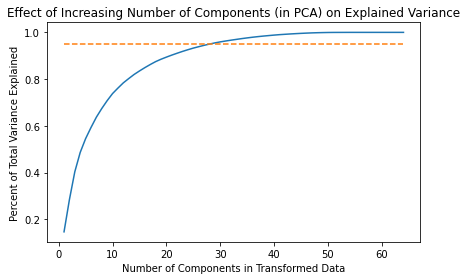

In [57]:
# Your code here
import numpy as np

n_components = list(range(1,X_train.shape[1]+1))
variance_explained = []
    
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    variance_explained.append(np.cumsum(pca.explained_variance_ratio_)[-1])
    
fig, ax = plt.subplots()

plt.plot(n_components, variance_explained)
plt.plot(n_components, [0.95]*len(n_components), ls='--')
ax.set(title='Effect of Increasing Number of Components (in PCA) on Explained Variance',
       xlabel='Number of Components in Transformed Data',
       ylabel='Percent of Total Variance Explained')

fig.tight_layout();

## Determine the number of features to capture 95% of the variance

Great! Now determine the number of features needed to capture 95% of the dataset's overall variance.

In [58]:
# Your code here
for n in n_components:
    pca = PCA(n_components=n)
    pca.fit(X_train)
    if np.cumsum(pca.explained_variance_ratio_)[-1] >= 0.95:
        break
    else:
        continue
        
print(n)

29


## Subset the dataset to these principal components which capture 95% of the overall variance

Use your knowledge to reproject the dataset into a lower-dimensional space using PCA. 

In [60]:
# Your code here
X_transformed = pca.transform(X_train)

## Refit a model on the compressed dataset

Now, refit a classification model to the compressed dataset. Be sure to time the required training time, as well as the test and training accuracy.

In [62]:
# Your code here
clf = SVC(gamma='auto')
start = time.time()
clf.fit(X_transformed, y_train)
end = time.time()
print(f'Training time: {1000*(end - start)} microseconds')

train_acc = accuracy_score(y_train, clf.predict(X_transformed))
test_acc = accuracy_score(y_test, clf.predict(pca.transform(X_test)))
print('Training Accuracy: {}\nTesting Accuracy: {}'.format(train_acc, test_acc))

Training time: 140.95592498779297 microseconds
Training Accuracy: 1.0
Testing Accuracy: 0.14888888888888888


### Grid search

Finally, use grid search to find optimal hyperparameters for the classifier on the reduced dataset. Be sure to record the time required to fit the model, the optimal hyperparameters and the test and train accuracy of the resulting model.

In [64]:
# Your code here
# ⏰ Your code may take several minutes to run
from sklearn.pipeline import Pipeline

clf = SVC()

pipe = Pipeline(steps=[
    ('pca', pca),
    ('clf', clf)
])

param_grid = [
    {'clf__C': [0.001, 0.01, 0.1, 1, 100, 1000],
     'clf__gamma': [0.001, 0.01, 0.1, 1]}
]

search = GridSearchCV(pipe, param_grid, return_train_score=True)

search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('pca', PCA(n_components=29)),
                                       ('clf', SVC())]),
             param_grid=[{'clf__C': [0.001, 0.01, 0.1, 1, 100, 1000],
                          'clf__gamma': [0.001, 0.01, 0.1, 1]}],
             return_train_score=True)

In [65]:
# Print the best parameters 
search.best_params_

{'clf__C': 100, 'clf__gamma': 0.001}

In [66]:
# store cv_results_ as dataframe
search_results = pd.DataFrame(search.cv_results_)
# find mean train score for best estimator
mean_train=search_results.loc[search_results.params==search.best_params_, 'mean_train_score']
# inspect
print(type(mean_train))
mean_train

<class 'pandas.core.series.Series'>


16    1.0
Name: mean_train_score, dtype: float64

In [67]:
# Print the training and test accuracy 
train_acc = mean_train[16]
test_acc = search.best_score_
print('Training Accuracy: {}\tTesting Accuracy: {}'.format(train_acc, test_acc))

Training Accuracy: 1.0	Testing Accuracy: 0.9918325760704942


Look at results on hold out test set and see confusion matrix.

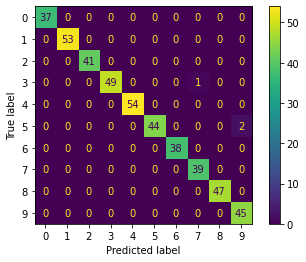

In [71]:
from sklearn.base import clone
from sklearn.metrics import ConfusionMatrixDisplay, plot_confusion_matrix

# clone & fit PCA + SVC pipeline with best parameters to all training data
best_pipe = clone(search.best_estimator_)
best_pipe.fit(X_train, y_train)

# view confusion matrix
ConfusionMatrixDisplay(plot_confusion_matrix(best_pipe, X_test, y_test));

In [72]:
len(y_test)

450

Wow! Only one image was mis-classified out of 450 images.

The model mis-classified a 3 as a 7. Is it a sign that there is room for improvement in the model, or is this 3 poorly written?

In [73]:
y_test_preds = best_pipe.predict(X_test)
np.argmin((y_test == y_test_preds))

47

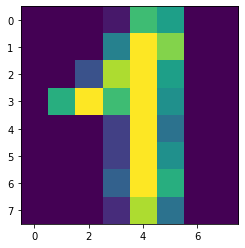

In [75]:
plt.imshow(data.images[47]);

Oh. I just realized that it is more difficult than expected to go back to the original image from the predictions and the test set because we are just dealing with numpy arrays here, not Pandas DataFrames, so when the train test split function shuffled my original data to create the train and test sets, there is no reliable index to connect them back to the original array. =(

## Summary

Well done! In this lab, you employed PCA to reduce a high dimensional dataset. With this, you observed the potential cost benefits required to train a model and performance gains of the model itself.